In [1]:
import numpy as np
import pandas as pd
import math
from collections import Counter
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import gif

In [2]:
df = pd.read_csv("../../data/space-track-gp/gp_20201214.csv.gz")
df['LAUNCH_DATE'] = pd.to_datetime(df['LAUNCH_DATE'], format='%Y-%m-%d')
df['DECAY_DATE'] = pd.to_datetime(df['DECAY_DATE'], format='%Y-%m-%d')

In [3]:
df['EPOCH'].head()

0    2020-12-12T15:16:44.294592
1    2020-11-13T20:25:31.231488
2    2020-11-21T03:46:46.331616
3    2020-12-06T10:55:57.922464
4    2020-12-12T16:01:48.374400
Name: EPOCH, dtype: object

In [34]:
def load_satellite_data():
    '''
    Loads the pandas dataframe for current satellite tracking
    '''
    gpd_df = pd.read_csv("../../data/space-track-gp/gp_20210129.csv.gz")
    sat_df = pd.read_pickle("../../data/satcat_incl_breakup_dates.pkl.gz")

    columns = [c for c in gpd_df.columns]

    gpd_df['LAUNCH_DATE'] = pd.to_datetime(gpd_df['LAUNCH_DATE'], format='%Y-%m-%d')
    gpd_df['DECAY_DATE'] = pd.to_datetime(gpd_df['DECAY_DATE'], format='%Y-%m-%d')

    gpd_df = pd.merge(gpd_df, sat_df, how='left', on='NORAD_CAT_ID')

    gpd_df['LAUNCH_DATE'] = gpd_df.apply(lambda x: x['LAUNCH_DATE'] if x['exist_date'] is None else x['exist_date'], axis=1)
    gpd_df = gpd_df.rename(columns={'OBJECT_TYPE_y': 'OBJECT_TYPE'})

    # Extend RCS_SIZE description
    rcs_map = {'SMALL':'Small (< 0.1m^2)', 'MEDIUM':'Medium (0.1m^2 - 1m^2)','LARGE': 'Large (>1m^2)', 'X': 'Unknown'}
    gpd_df['RCS_SIZE_NAME'] = gpd_df['RCS_SIZE'].fillna('X').map(rcs_map)
    columns.append('RCS_SIZE_NAME')

    # Setup marker size based on RCS_SIZE
    size_map = {'SMALL':3, 'MEDIUM':4, 'LARGE':5}
    gpd_df['allsat_marker_size'] = gpd_df['RCS_SIZE'].fillna('MEDIUM').map(size_map)
    columns.append('allsat_marker_size')
        
    # Use full country (company) names
    ctry_map = {'PRC':'China', 'US':'USA', 'CIS':'Former USSR', 'UAE':'United Arab Emirates', 'JPN':'Japan', 'FR':'France',
                'ESA':'European Space Agency', 'NZ':'New Zealand', 'TBD':'Unknown', 'CA':'Canada', 'IND':'India',
                'LTU':'Lithuania', 'ARGN':'Argentina', 'GER':'Germany', 'FIN':'Finland', 'THAI':'Thailand', 'EST':'Estonia',
                'AUS':'Australia', 'SPN':'Spain', 'ISRA':'Israel', 'BEL':'Belgium', 'SVN':'Slovenia', 'IT':'Italy',
                'SKOR':'South Korea', 'IRAN':'Iran', 'ORB':'Orbcomm', 'ITSO':'ITSO', 'UK':'UK', 'EUTE':'Eutelsat', 
                'CHBZ':'China/Brazil', 'IM':'Inmarsat', 'EGYP':'Egypt', 'RWA':'Rwanda', 'ISS':'International Space Station',
                'SDN':'SDN', 'POL':'Poland', 'MEX':'Mexico', 'ROC':'Taiwan', 'SING':'Singapore', 'LKA':'Sri Lanka',
                'NPL':'Nepal', 'AB':'Arab Sat Comm', 'O3B':'O3B Networks', 'SWTZ':'Switerland', 'INDO':'Indonesia',
                'GREC':'Greece', 'SAFR':'South Africa', 'SAUD':'Saudia Arabia', 'JOR':'Jordan', 'KAZ':'Kazakhstan',
                'NETH':'Netherlands', 'COL':'Columbia', 'MA':'Morocco', 'QAT':'Qatar', 'EUME':'EUMETSAT', 'RP':'Philippines',
                'AZER':'Azerbaijan', 'PAKI':'Pakistan', 'SES':'Societe Europeenee Des Satellites', 'KEN':'Keyna',
                'BGD':'Bangladesh', 'DEN':'Denmark', 'AGO':'Angola', 'ALG':'Alteria', 'VENZ':'Venezuela', 'AC':'AsiaSat',
                'NOR':'Norway', 'BGR':'Bulgaria', 'CZCH':'Czech Republic', 'CHLE':'Chile', 'ASRA':'Austria', 'BRAZ':'Brazil',
                'TURK':'Turkey', 'PER':'Peru', 'BERM':'BERM', 'NKOR':'North Korea', 'BELA':'Belarus', 'LAOS':'Laos',
                'TMMC':'Turkmenistan/Monaco', 'MALA':'Malaysia', 'IRAQ':'Iraq', 'UKR':'Ukraine', 'URY':'Uruguay',
                'SEAL':'Sea Launch', 'FRIT':'France/Italy', 'BOL':'Bolivia', 'ECU':'Ecuador', 'VTNM':'Vietnam',
                'GLOB':'Globalstar', 'NIG':'Nigeria', 'LUXE':'Luxembourg', 'STCT':'Singapore/Taiwan', 'RASC':'RASCOM',
                'SWED':'Sweden', 'USBZ':'US/Brazil', 'NICO':'NEW ICO', 'NATO':'NATO', 'POR':'Portugal', 'FGER':'France/Germany'
                }
    gpd_df['COUNTRY_CODE'] = gpd_df['COUNTRY_CODE'].fillna('TBD')
    gpd_df['country'] = gpd_df['COUNTRY_CODE'].map(ctry_map)
    columns.append('country')

    
    return gpd_df[columns]

df = load_satellite_data()

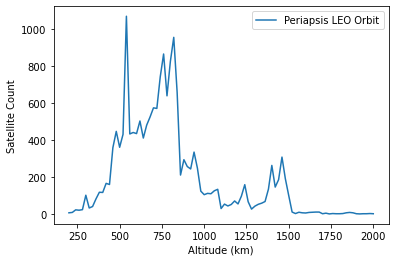

In [35]:
cross_counts = {}
in_counts = {}
peri_counts = {}
bin_size = 20
tolerance = 0

for alt in np.arange(200,2000+bin_size,bin_size):
    cross_count = len(df[(df['PERIAPSIS'] <= alt+bin_size) & (df['APOAPSIS'] >= alt) & (df['PERIAPSIS'] > 0)])
    cross_counts[alt] = cross_count
    in_count = len(df[(df['PERIAPSIS']>=alt-tolerance) & (df['APOAPSIS']<=alt+bin_size+tolerance)])
    in_counts[alt] = in_count
    peri_count = len(df[(df['PERIAPSIS']>=alt-tolerance) & 
                        (df['PERIAPSIS']<=alt+bin_size+tolerance) &
                        (df['MEAN_MOTION']>11.25) &
                        (df['ECCENTRICITY']<0.25) & (df['DECAY_DATE'].isnull())])
    peri_counts[alt] = peri_count
    

plt.figure()
x = cross_counts.keys()
y1 = cross_counts.values()
y2 = in_counts.values()
y3 = peri_counts.values()
#plt.plot(x,y1, label='Cross Orbit')
#plt.plot(x,y2, label='In Orbit')
plt.plot(x,y3, label='Periapsis LEO Orbit')
plt.xlabel("Altitude (km)")
plt.ylabel("Satellite Count")
plt.legend()
plt.show()

$Sphere Volume = \frac{4}{3}\pi r^3$

In [5]:
def altitude_band_volume(outer_radius,inner_radius):
    return 4/3*np.pi*math.pow(outer_radius,3) - \
           4/3*np.pi*math.pow(inner_radius,3)

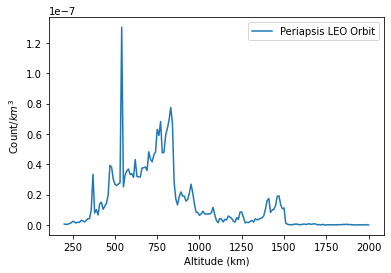

In [6]:
cross_density = {}
in_density = {}
peri_density = {}
earth_radius = 6371
bin_size = 10
tolerance = 0


for alt in np.arange(200,2000+bin_size,bin_size):
    spatial_vol = altitude_band_volume(earth_radius+alt+bin_size, earth_radius+alt)
    cross_count = len(df[(df['PERIAPSIS'] <= alt+bin_size) & (df['APOAPSIS'] >= alt) & (df['PERIAPSIS'] > 0)])
    cross_density[alt] = cross_count / spatial_vol
    in_count = len(df[(df['PERIAPSIS']>=alt-tolerance) & (df['APOAPSIS']<=alt+bin_size+tolerance)])
    in_density[alt] = in_count / spatial_vol
    peri_count = len(df[(df['PERIAPSIS']>=alt-tolerance) & 
                        (df['PERIAPSIS']<=alt+bin_size+tolerance) &
                        (df['MEAN_MOTION']>11.25) &
                        (df['ECCENTRICITY']<0.25) &
                        (df['DECAY_DATE'].isnull()) &
                        #((df['DECAY_DATE'].isnull()) | (df['DECAY_DATE'].dt.year > 2010)) &
                        (df['LAUNCH_DATE'].notnull()) 
                        #& (df['LAUNCH_DATE'] <= '2010-04-20')
                        #& (df['LAUNCH_DATE'] <= '2016-02-01')
                       ])
    peri_density[alt] = peri_count / spatial_vol

plt.figure()
x = cross_density.keys()
y1 = cross_density.values()
y2 = in_density.values()
y3 = peri_density.values()
#plt.plot(x,y1, label='Cross Orbit')
#plt.plot(x,y2, label='In Orbit')
plt.plot(x,y3, label='Periapsis LEO Orbit')
plt.xlabel("Altitude (km)")
plt.ylabel("Count/$km^3$")
plt.legend()
plt.show()

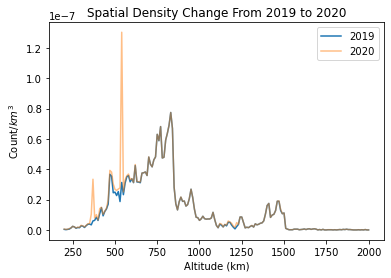

In [7]:
counts = {}
densitys = {}

# Retrieve all counts and densitys for upto year 2019
counts[2019] = {}
densitys[2019] = {}
for alt in np.arange(200,2000+bin_size,bin_size):
    spatial_vol = altitude_band_volume(earth_radius+alt+bin_size, earth_radius+alt)
    counts[2019][alt] = len(df[(df['PERIAPSIS']>=alt-tolerance) & 
                        (df['PERIAPSIS']<=alt+bin_size+tolerance) &
                        (df['MEAN_MOTION']>11.25) &
                        (df['ECCENTRICITY']<0.25) &
                        (df['DECAY_DATE'].isnull()) &
                        ((df['LAUNCH_DATE'].dt.year <= 2019))
                       ])
    densitys[2019][alt] = counts[2019][alt] / spatial_vol

counts[2020] = {}
densitys[2020] = {}
for alt in np.arange(200,2000+bin_size,bin_size):
    spatial_vol = altitude_band_volume(earth_radius+alt+bin_size, earth_radius+alt)
    counts[2020][alt] = len(df[(df['PERIAPSIS']>=alt-tolerance) & 
                        (df['PERIAPSIS']<=alt+bin_size+tolerance) &
                        (df['MEAN_MOTION']>11.25) &
                        (df['ECCENTRICITY']<0.25) &
                        (df['DECAY_DATE'].isnull()) &
                        ((df['LAUNCH_DATE'].dt.year <= 2020))
                       ])
    densitys[2020][alt] = counts[2020][alt] / spatial_vol
    
plt.figure()
x = densitys[2019].keys()
y2019 = densitys[2019].values()
y2020 = densitys[2020].values()
plt.plot(x,y2019, label='2019')
plt.plot(x,y2020, label='2020', alpha=0.5)
plt.xlabel("Altitude (km)")
plt.ylabel("Count/$km^3$")
plt.title("Spatial Density Change From 2019 to 2020")
plt.legend()
plt.show()

In [56]:
earth_radius = 6371
bin_size = 10
bins = np.arange(200,2000+bin_size,bin_size)
built_df = pd.DataFrame()
start = int(df['LAUNCH_DATE'].dt.year.min())
df = df.dropna(subset=['LAUNCH_DATE'])
df['ALT_BIN'] = pd.cut(df['PERIAPSIS'], bins=bins, labels=bins[:-1])

for y in np.arange(start,2021):
    tmp_df = df[((df['MEAN_MOTION']>11.25) | (df['PERIAPSIS'] < 900)) &
                ((df['ECCENTRICITY']<0.25)  )&
                ((df['DECAY_DATE'].isnull()) | (df['DECAY_DATE'].dt.year > y+1)) &
                (df['LAUNCH_DATE'].dt.year <= y)].groupby('ALT_BIN')['CCSDS_OMM_VERS'].count().reset_index()
    tmp_df.columns = ['ALT','ALL_COUNT']
    tmp_df['YEAR'] = y
    built_df = pd.concat([built_df,tmp_df])
    
# for y in np.arange(start,2021):
#     tmp_df = df[(df['MEAN_MOTION']>11.25) &
#                 (df['ECCENTRICITY']<0.25) &
#                 ((df['DECAY_DATE'].isnull()) | (df['DECAY_DATE'].dt.year > y+2)) &
#                 (df['LAUNCH_DATE'].dt.year <= y)].groupby('ALT_BIN')['CCSDS_OMM_VERS'].count().reset_index()
#     tmp_df.columns = ['ALT','ALL_COUNT']
#     tmp_df['YEAR'] = y
#     built_df = pd.concat([built_df,tmp_df])

built_df['ALL_DENSITY'] = built_df.apply(lambda x: x['ALL_COUNT'] / altitude_band_volume(earth_radius+x['ALT']+bin_size, earth_radius+x['ALT']), axis=1)


fig = px.line(built_df, x="ALT", y="ALL_DENSITY", #title='Satellite Density in Low Earth Orbit (LEO) by Year',
              animation_frame="YEAR", range_x=[200,2000], range_y=[0,0.00000013],
              labels={
                  "ALT": "$Altitude (km)$",
                  "ALL_DENSITY": "$Count/km^3$",
                  "YEAR": "Year"
              })

# Annotate last frame
fig.add_annotation(
    x=545,
    y=0.0000001,
    text='Starlink Satellites',
    showarrow=True,
    arrowhead=2,
    arrowsize=1,
    arrowwidth=2,
    ax=100,
    ay=0
)
# Add Year
fig.add_annotation(
    x=1700,
    y=0.00000011,
    text='2020',
    showarrow=False,
    font=dict(size=50,color="#999999")
)

fig.add_shape(dict(type="circle", x0=730, x1=930, y0=0.00000004, y1=0.00000008, fillcolor="red", line_color='red', opacity=.1, layer="below"))
fig.add_annotation(x=1700, y=0.00000009, text='FengYun-1C Missle Test', showarrow=False, font=dict(size=15,color="#ff0000"), opacity = 1)
fig.add_shape(dict(type="circle", x0=650, x1=850, y0=0.00000003, y1=0.00000007, fillcolor="red", line_color='red', opacity=.1, layer="below"))
fig.add_annotation(x=1700, y=0.00000008, text='Iridium 33/Kosmos-2251 Collision', showarrow=False, font=dict(size=15,color="#ff0000"), opacity = 1)

for button in fig.layout.updatemenus[0].buttons:
    button['args'][1]['frame']['redraw'] = True
    
for k in range(len(fig.frames)):
    fig.frames[k]['layout'].update(title_text=f'Satellite Density in Low Earth Orbit (LEO) in {start+k}')
    
# Set last frame as default
last_frame_num = len(fig.frames) -1
fig.layout['sliders'][0]['active'] = last_frame_num
fig = go.Figure(data=fig['frames'][-1]['data'], frames=fig['frames'], layout=fig.layout)

        
fig.show()

In [67]:
@gif.frame
def make_gif(built_df, y):
    df = built_df[built_df['YEAR']==y]

    fig = px.line(df, x="ALT", y="ALL_DENSITY", title=f'Satellite Density in Low Earth Orbit (LEO) by Year',
                  range_x=[200,2000], range_y=[0,0.00000013],
                  labels={
                      "ALT": "$Altitude (km)$",
                      "ALL_DENSITY": "$Count/km^3$",
                      "YEAR": "Year"
                  })
    
    # Add Year
    fig.add_annotation(
        x=1700,
        y=0.00000011,
        text=str(y),
        showarrow=False,
        font=dict(size=50,color="#999999")
    )
    if y > 2009:
        # Annotate last frame
        fig.add_annotation(
            x=545,
            y=0.0000001,
            text='Starlink Satellites',
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            ax=100,
            ay=0,
            opacity = (y-2010)/ 10
        )
        
    if y > 2006 and y <= 2016:
        perc = (2017-y)/10
        x_center = 830
        x_max = 150
        y_center = 0.00000006
        y_max = 0.00000002
        fig.add_shape(dict(type="circle",
                           x0=x_center-(x_max*perc),
                           x1=x_center+(x_max*perc),
                           y0=y_center-(y_max*perc),
                           y1=y_center+(y_max*perc),
                           fillcolor="red", line_color='red', opacity=perc, layer="below"))
    if y > 2008 and y <= 2018:
        perc = (2019-y)/10
        x_center = 750
        x_max = 150
        y_center = 0.00000005
        y_max = 0.00000002
        fig.add_shape(dict(type="circle",
                           x0=x_center-(x_max*perc),
                           x1=x_center+(x_max*perc),
                           y0=y_center-(y_max*perc),
                           y1=y_center+(y_max*perc),
                           fillcolor="orange", line_color='orange', opacity=perc, layer="below"))
        
    fig.add_annotation(x=1400, y=0.000000095, text='FengYun-1C Missle Test', showarrow=False, font=dict(size=15,color="red"), opacity=1, xanchor="left")
    fig.add_annotation(x=1400, y=0.000000082, text='Iridium 33/Kosmos-2251<br>Collision', showarrow=False, font=dict(size=15,color="orange"), opacity=1, xanchor="left")
    return fig

frames = []
last_frame = make_gif(built_df, 2020) 
for y in np.arange(start,2020):
    frame = make_gif(built_df, y)
    frames.append(frame)
frames.extend([last_frame]*10) # show last frame x10
gif.save(frames, './spatial.gif', duration=250)

# Investigation into 2020 spikes

In [69]:
pd.set_option('display.max_columns', 500)
y = 2019
df19 = df[(df['MEAN_MOTION']>11.25) &
                (df['ECCENTRICITY']<0.25) &
                ((df['DECAY_DATE'].isnull()) | (df['DECAY_DATE'].dt.year > y+2)) &
                (df['LAUNCH_DATE'].dt.year <= y)]
y = 2020
df20 = df[(df['MEAN_MOTION']>11.25) &
                (df['ECCENTRICITY']<0.25) &
                ((df['DECAY_DATE'].isnull()) | (df['DECAY_DATE'].dt.year > y+2)) &
                (df['LAUNCH_DATE'].dt.year <= y)]


print(f'2019 Satellite count: {len(df19)}')
print(f'2020 Satellite count: {len(df20)} (+{len(df20)-len(df19)} / +{round((len(df20)-len(df19))/len(df19)*100,2)}%)')

2019 Satellite count: 14757
2020 Satellite count: 16229 (+1472 / +9.97%)


In [70]:
built_df = pd.DataFrame()

for y in np.arange(start,2021):
    tmp_df = df[(df['MEAN_MOTION']>11.25) &
                (df['ECCENTRICITY']<0.25) &
                ((df['DECAY_DATE'].isnull()) | (df['DECAY_DATE'].dt.year > y+2)) &
                (df['LAUNCH_DATE'].dt.year == y)].groupby('ALT_BIN')['CCSDS_OMM_VERS'].count().reset_index()
    tmp_df.columns = ['ALT','ALL_COUNT']
    tmp_df['YEAR'] = y
    built_df = pd.concat([built_df,tmp_df])
    
fig = px.line(built_df, x="ALT", y="ALL_COUNT", title='Satellite Orbit Increase by Year',
              animation_frame="YEAR", range_x=[200,2000], range_y=[0,600])
fig.show()

In [71]:
df[df['OBJECT_NAME'].str.startswith('STARLINK')].sort_values('CREATION_DATE').head()

,Unnamed: 0,CCSDS_OMM_VERS,COMMENT,CREATION_DATE,ORIGINATOR,OBJECT_NAME,OBJECT_ID,CENTER_NAME,REF_FRAME,TIME_SYSTEM,MEAN_ELEMENT_THEORY,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,CLASSIFICATION_TYPE,NORAD_CAT_ID,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,OBJECT_TYPE,RCS_SIZE,COUNTRY_CODE,LAUNCH_DATE,SITE,DECAY_DATE,FILE,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2,RCS_SIZE_NAME,allsat_marker_size,country,ALT_BIN
4136,4136,2.0,GENERATED VIA SPACE-TRACK.ORG API,2020-02-20T21:36:25,18 SPCS,STARLINK-46,2019-029M,EARTH,TEME,UTC,SGP4,2020-02-20T12:53:54.492000,16.400639,0.002696,52.9662,262.5732,244.6149,115.2104,0,U,44246,999,4270,0.000769,0.176585,0.000012,6543.769,87.801,183.278,147.990,PAYLOAD,LARGE,US,2019-05-24,AFETR,2020-02-20,2706890,149154971,0 STARLINK-46,1 44246U 19029M 20051.53743625 .17658540 1...,2 44246 52.9662 262.5732 0026963 244.6149 115...,Large (>1m^2),5,USA,NaN
3182,3182,2.0,GENERATED VIA SPACE-TRACK.ORG API,2020-03-09T22:46:17,18 SPCS,STARLINK-1220,2020-012AK,EARTH,TEME,UTC,SGP4,2020-03-09T22:00:00.999936,15.757463,0.002745,53.0024,162.4808,118.7601,331.9927,0,U,45211,999,370,0.004159,0.007232,0.000000,6720.645,91.385,360.959,324.062,PAYLOAD,LARGE,US,2020-02-17,AFETR,2020-02-29,2715913,150318730,0 STARLINK-1220,1 45211U 20012AK 20069.91667824 .00723224 0...,2 45211 53.0024 162.4808 0027451 118.7601 331...,Large (>1m^2),5,USA,320
3436,3436,2.0,GENERATED VIA SPACE-TRACK.ORG API,2020-04-02T18:11:05,18 SPCS,STARLINK-1118,2020-001AL,EARTH,TEME,UTC,SGP4,2020-04-02T02:46:14.129184,16.333338,0.000646,52.9916,320.6390,255.8970,104.1355,0,U,44948,999,1367,0.001532,0.100264,0.000012,6561.733,88.163,187.835,179.360,PAYLOAD,LARGE,US,2020-01-07,AFETR,2020-04-02,2727577,151494381,0 STARLINK-1118,1 44948U 20001AL 20093.11544131 +.10026385 +1...,2 44948 052.9916 320.6390 0006458 255.8970 104...,Large (>1m^2),5,USA,NaN
4104,4104,2.0,GENERATED VIA SPACE-TRACK.ORG API,2020-05-27T09:56:08,18 SPCS,STARLINK-67,2019-029AV,EARTH,TEME,UTC,SGP4,2020-05-27T08:59:56.976864,16.441254,0.000550,52.9725,113.8189,260.1827,100.3413,0,U,44278,999,5853,0.001249,0.352143,0.000012,6532.988,87.585,158.445,151.262,PAYLOAD,LARGE,US,2019-05-24,AFETR,2020-05-27,2754782,154608628,0 STARLINK-67,1 44278U 19029AV 20148.37496501 .35214307 1...,2 44278 52.9725 113.8189 0005497 260.1827 100...,Large (>1m^2),5,USA,NaN
3419,3419,2.0,GENERATED VIA SPACE-TRACK.ORG API,2020-05-29T07:06:09,18 SPCS,STARLINK-1087,2020-001BD,EARTH,TEME,UTC,SGP4,2020-05-28T22:41:27.804480,16.437271,0.000898,52.9928,43.5355,226.1131,134.4631,0,U,44965,999,2327,0.001210,0.343951,0.000012,6534.044,87.606,161.776,150.042,PAYLOAD,LARGE,US,2020-01-07,AFETR,2020-05-29,2755878,154713658,0 STARLINK-1087,1 44965U 20001BD 20149.94546070 .34395127 1...,2 44965 52.9928 43.5355 0008979 226.1131 134...,Large (>1m^2),5,USA,NaN


Text(0.5, 1.0, 'Starlink Satellites Launched')

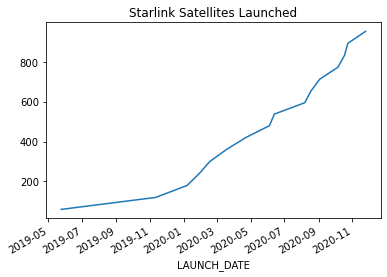

In [72]:
starlink_cnt_df = df[df['OBJECT_NAME'].str.startswith('STARLINK')].groupby('LAUNCH_DATE').count()['NORAD_CAT_ID'].cumsum()
starlink_cnt_df.index = pd.to_datetime(starlink_cnt_df.index, format='%Y-%m-%d')
starlink_cnt_df.plot().set_title('Starlink Satellites Launched')

In [73]:
# All future data source manaully created based
# on source: https://spacenews.com/spacex-submits-paperwork-for-30000-more-starlink-satellites/

# Based on 955 end of 2020 and additional 60 satellites every 2 weeks in 2021
starlink_cnt_df.loc['2021-12-31'] = 2515

#https://en.wikipedia.org/wiki/Starlink#Technology0
starlink_cnt_df.loc['2024-03-24'] = 2515


starlink_cnt_df

LAUNCH_DATE
2019-05-24 00:00:00      60
2019-11-11 00:00:00     120
2020-01-07 00:00:00     180
2020-01-29 00:00:00     240
2020-02-17 00:00:00     300
2020-03-18 00:00:00     360
2020-04-22 00:00:00     420
2020-06-04 00:00:00     480
2020-06-13 00:00:00     538
2020-08-07 00:00:00     595
2020-08-18 00:00:00     653
2020-09-03 00:00:00     713
2020-10-06 00:00:00     773
2020-10-18 00:00:00     833
2020-10-24 00:00:00     893
2020-11-25 00:00:00     953
2021-12-31             2515
2024-03-24             2515
Name: NORAD_CAT_ID, dtype: int64

In [74]:
df[(df['MEAN_MOTION']>11.25) &
                (df['ECCENTRICITY']<0.25) &
                ((df['DECAY_DATE'].isnull()) | (df['DECAY_DATE'].dt.year > y+2)) &
                (df['LAUNCH_DATE'].dt.year == 2020)]


,Unnamed: 0,CCSDS_OMM_VERS,COMMENT,CREATION_DATE,ORIGINATOR,OBJECT_NAME,OBJECT_ID,CENTER_NAME,REF_FRAME,TIME_SYSTEM,MEAN_ELEMENT_THEORY,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,CLASSIFICATION_TYPE,NORAD_CAT_ID,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,OBJECT_TYPE,RCS_SIZE,COUNTRY_CODE,LAUNCH_DATE,SITE,DECAY_DATE,FILE,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2,RCS_SIZE_NAME,allsat_marker_size,country,ALT_BIN
1111,1111,2.0,GENERATED VIA SPACE-TRACK.ORG API,2021-01-28T20:49:41,18 SPCS,CZ-4C R/B,2020-103C,EARTH,TEME,UTC,SGP4,2021-01-28T09:59:52.550016,14.891421,0.011547,98.3192,280.0108,301.5947,57.4039,0,U,47304,999,472,0.000029,2.310000e-06,0.0,6978.752,96.700,681.198,520.035,ROCKET BODY,LARGE,PRC,2020-12-27 00:00:00,JSC,NaT,2942815,170577779,0 CZ-4C R/B,1 47304U 20103C 21028.41658044 .00000231 0...,2 47304 98.3192 280.0108 0115467 301.5947 57...,Large (>1m^2),5,China,520
1112,1112,2.0,GENERATED VIA SPACE-TRACK.ORG API,2021-01-28T22:56:10,18 SPCS,WEINA 2,2020-103B,EARTH,TEME,UTC,SGP4,2021-01-28T21:50:42.957888,14.591240,0.000151,98.2708,278.7744,71.3841,288.7525,0,U,47303,999,471,0.000046,1.690000e-06,0.0,7074.141,98.689,697.071,694.941,PAYLOAD,MEDIUM,PRC,2020-12-27 00:00:00,JSC,NaT,2943086,170584242,0 WEINA 2,1 47303U 20103B 21028.91021942 .00000169 0...,2 47303 98.2708 278.7744 0001506 71.3841 288...,Medium (0.1m^2 - 1m^2),4,China,690
1113,1113,2.0,GENERATED VIA SPACE-TRACK.ORG API,2021-01-28T22:56:10,18 SPCS,YAOGAN-33,2020-103A,EARTH,TEME,UTC,SGP4,2021-01-28T20:36:07.390368,14.591212,0.000145,98.2701,278.6782,101.7888,258.3477,0,U,47302,999,470,0.000024,6.800000e-07,0.0,7074.150,98.690,697.039,694.991,PAYLOAD,LARGE,PRC,2020-12-27 00:00:00,JSC,NaT,2943071,170583557,0 YAOGAN-33,1 47302U 20103A 21028.85841887 .00000068 0...,2 47302 98.2701 278.6782 0001447 101.7888 258...,Large (>1m^2),5,China,690
1114,1114,2.0,GENERATED VIA SPACE-TRACK.ORG API,2021-01-29T02:31:30,18 SPCS,CZ-8 R/B,2020-102F,EARTH,TEME,UTC,SGP4,2021-01-28T19:28:23.326176,15.366208,0.010418,97.4395,129.6248,26.4962,334.1555,0,U,47301,999,577,0.000080,3.332000e-05,0.0,6834.247,93.712,527.312,384.913,ROCKET BODY,LARGE,PRC,2020-12-22 00:00:00,WSC,NaT,2943156,170606140,0 CZ-8 R/B,1 47301U 20102F 21028.81138109 .00003332 0...,2 47301 97.4395 129.6248 0104181 26.4962 334...,Large (>1m^2),5,China,380
1115,1115,2.0,GENERATED VIA SPACE-TRACK.ORG API,2021-01-28T22:46:09,18 SPCS,OBJECT E,2020-102E,EARTH,TEME,UTC,SGP4,2021-01-28T21:33:03.064896,15.205492,0.000452,97.4344,128.7726,7.8470,102.3529,0,U,47300,999,572,0.000100,2.116000e-05,0.0,6882.320,94.703,507.298,501.072,TBA,MEDIUM,TBD,2020-12-22 00:00:00,WSC,NaT,2943024,170582093,0 OBJECT E,1 47300U 20102E 21028.89795214 .00002116 0...,2 47300 97.4344 128.7726 0004523 7.8470 102...,Medium (0.1m^2 - 1m^2),4,Unknown,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3468,3468,2.0,GENERATED VIA SPACE-TRACK.ORG API,2021-01-29T02:31:30,18 SPCS,STARLINK-1097,2020-001C,EARTH,TEME,UTC,SGP4,2021-01-28T15:37:23.769984,15.055766,0.000095,53.0004,83.5886,95.6679,264.4417,0,U,44916,999,5859,0.000006,-1.900000e-06,0.0,6927.873,95.644,550.397,549.080,PAYLOAD,LARGE,US,2020-01-07 00:00:00,AFETR,NaT,2943156,170605225,0 STARLINK-1097,1 44916U 20001C 21028.65096956 -.00000190 0...,2 44916 53.0004 83.5886 0000950 95.6679 264...,Large (>1m^2),5,USA,540
3469,3469,2.0,GENERATED VIA SPACE-TRACK.ORG API,2021-01-29T02:31:30,18 SPCS,STARLINK-1084,2020-001B,EARTH,TEME,UTC,SGP4,2021-01-28T15:23:03.393600,15.055804,0.000104,53.0007,83.6331,90.8497,269.2610,0,U,44915,999,5859,-0.000012,-4.590000e-06,0.0,6927.862,95.644,550.444,549.009,PAYLOAD,LARGE,US,2020-01-07 00:00:00,AFETR,NaT,2943156,170604981,0 STARLINK-1084,1 44915U 20001B 21028.64101150 -.00000459 0...,2 44915 53.0007 83.6331 0001036 90.8497 269

## Count by Year

In [75]:
df = pd.read_csv("../../data/space-track-gp/gp_20201214.csv.gz")
df['LAUNCH_DATE'] = pd.to_datetime(df['LAUNCH_DATE'], format='%Y-%m-%d')
df['DECAY_DATE'] = pd.to_datetime(df['DECAY_DATE'], format='%Y-%m-%d')

In [76]:
pd.DataFrame([0], columns=['CCSDS_OMM_VERS'], index=[1958])

,CCSDS_OMM_VERS
1958,0


In [77]:
df[(df['MEAN_MOTION']>11.25) & (df['ECCENTRICITY']<0.25) & (df['LAUNCH_DATE'].dt.year == 1999)]

,CCSDS_OMM_VERS,COMMENT,CREATION_DATE,ORIGINATOR,OBJECT_NAME,OBJECT_ID,CENTER_NAME,REF_FRAME,TIME_SYSTEM,MEAN_ELEMENT_THEORY,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,CLASSIFICATION_TYPE,NORAD_CAT_ID,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,OBJECT_TYPE,RCS_SIZE,COUNTRY_CODE,LAUNCH_DATE,SITE,DECAY_DATE,FILE,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2
1019,2.0,GENERATED VIA SPACE-TRACK.ORG API,2020-12-13T05:18:45,18 SPCS,FENGYUN 1C DEB,1999-025FCE,EARTH,TEME,UTC,SGP4,2020-12-12T11:54:29.941632,15.001918,0.006624,98.4231,175.4992,297.0674,62.3799,0,U,47106,999,23383,0.001381,0.000180,0.000000e+00,6944.441,95.987,612.302,520.309,DEBRIS,NaN,PRC,1999-05-10,TSC,NaT,2902034,167687681,0 FENGYUN 1C DEB,1 47106U 99025FCE 20347.49617988 .00018035 0...,2 47106 98.4231 175.4992 0066235 297.0674 62...
1020,2.0,GENERATED VIA SPACE-TRACK.ORG API,2020-12-07T17:48:54,18 SPCS,FENGYUN 1C DEB,1999-025FCD,EARTH,TEME,UTC,SGP4,2020-12-05T06:21:53.865792,15.682142,0.000535,98.4978,205.2668,67.5483,292.6341,0,U,47105,999,23729,0.031180,0.040662,0.000000e+00,6742.147,91.824,367.622,360.402,DEBRIS,NaN,PRC,1999-05-10,TSC,2020-12-07,2899016,167190209,0 FENGYUN 1C DEB,1 47105U 99025FCD 20340.26520678 +.04066156 +0...,2 47105 098.4978 205.2668 0005354 067.5483 292...
1021,2.0,GENERATED VIA SPACE-TRACK.ORG API,2020-12-11T20:18:04,18 SPCS,FENGYUN 1C DEB,1999-025FCC,EARTH,TEME,UTC,SGP4,2020-12-11T04:44:27.123360,14.172809,0.004221,98.9385,332.8433,145.0801,215.3155,0,U,47104,999,36471,0.000081,0.000001,0.000000e+00,7212.700,101.603,865.011,804.118,DEBRIS,NaN,PRC,1999-05-10,TSC,NaT,2901310,167520608,0 FENGYUN 1C DEB,1 47104U 99025FCC 20346.19753615 .00000121 0...,2 47104 98.9385 332.8433 0042212 145.0801 215...
1022,2.0,GENERATED VIA SPACE-TRACK.ORG API,2020-12-10T21:26:10,18 SPCS,FENGYUN 1C DEB,1999-025FCB,EARTH,TEME,UTC,SGP4,2020-12-10T11:18:13.041792,14.004236,0.018295,97.9691,66.2819,151.7365,209.3878,0,U,47103,999,43603,0.000295,0.000005,0.000000e+00,7270.465,102.826,1025.341,759.320,DEBRIS,NaN,PRC,1999-05-10,TSC,NaT,2900688,167443630,0 FENGYUN 1C DEB,1 47103U 99025FCB 20345.47098428 .00000471 0...,2 47103 97.9691 66.2819 0182946 151.7365 209...
1023,2.0,GENERATED VIA SPACE-TRACK.ORG API,2020-12-13T14:26:09,18 SPCS,FENGYUN 1C DEB,1999-025FCA,EARTH,TEME,UTC,SGP4,2020-12-13T08:56:05.447328,14.068705,0.013302,98.3731,24.2255,239.2284,131.7800,0,U,47102,999,43945,0.000215,0.000003,0.000000e+00,7248.237,102.354,966.520,773.685,DEBRIS,NaN,PRC,1999-05-10,TSC,NaT,2902248,167692880,0 FENGYUN 1C DEB,1 47102U 99025FCA 20348.37228527 .00000347 0...,2 47102 98.3731 24.2255 0133022 239.2284 131...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22053,2.0,GENERATED VIA SPACE-TRACK.ORG API,2020-12-13T22:26:10,18 SPCS,GLOBALSTAR M040,1999-004B,EARTH,TEME,UTC,SGP4,2020-12-13T20:38:06.414144,12.619025,0.000027,51.9939,27.6632,25.9585,145.4404,0,U,25622,999,769,0.000009,-0.000001,0.000000e+00,7793.238,114.113,1415.310,1414.897,PAYLOAD,LARGE,GLOB,1999-02-09,TTMTR,NaT,2902497,167741686,0 GLOBALSTAR M040,1 25622U 99004B 20348.85979646 -.00000102 0...,2 25622 51.9939 27.6632 0000265 25.9585 145...
22054,2.0,GENERATED VIA SPACE-TRACK.ORG API,2020-12-13T20:07:11,18 SPCS,GLOBALSTAR M023,1999-004A,EARTH,TEME,UTC,SGP4,2020-12-13T03:29:20.567616,12.623984,0.001003,52.0131,28.0714,92.2475,318.1039,0,U,25621,999,776,-0.000318,-0.000002,0.000000e+00,7791.197,114.068,1420.880,1405.245,PAYLOAD,LARGE,GLOB,1999-02-09,TTMTR,NaT,2902446,167703909,0 GLOBALSTAR M023,1 25621U 99004A 20348.14537694 -.00000161 0...,2 25621 52.0131 28.0714 0010034 92.2475 318...
22056,2.0,GENERATED VIA SPACE-TRACK.ORG API,2004-08-17T15:23:51,18 SPCS,ATHENA 1 R/B(OAM),1999-002B,EARTH,TEME,UTC,SGP4,1999-01-29T19:45:37.636992,16.363550,0.009123,34.6813,265.1030,231.5977,127.7797,0,U,25617,

In [78]:
df = df.dropna(subset=['LAUNCH_DATE'])
count_df = df[(df['MEAN_MOTION']>11.25) & (df['ECCENTRICITY']<0.25)].groupby(df['LAUNCH_DATE'].dt.year)[['CCSDS_OMM_VERS']].count()
decay_df = df[(df['MEAN_MOTION']>11.25) & (df['ECCENTRICITY']<0.25)].groupby(df['DECAY_DATE'].dt.year)[['CCSDS_OMM_VERS']].count()
decay_df = decay_df.append(pd.DataFrame([0], columns=['CCSDS_OMM_VERS'], index=[1958]))
count_df = (count_df - decay_df).cumsum()
count_df.columns = ['count']

fig = px.line(count_df, x=count_df.index, y='count', title='Satellites in LEO by Year',
              labels={"index": "Year","count": "Number of Satellites"})


fig.add_trace(go.Scatter(x=[1981.5],y=[6550],showlegend=False,marker=dict(size=12,color='green'),
                         hovertemplate='Space Shuttle enters service in April 1981<extra></extra>'))

fig.add_trace(go.Scatter(x=[2011.5],y=[15400],showlegend=False,marker=dict(size=12,color='green'),
                         hovertemplate='Space Shuttle last flight in July 2011<extra></extra>'))

fig.add_trace(go.Scatter(x=[1998.5],y=[14000],showlegend=False,marker=dict(size=12,color='green'),
                         hovertemplate='Debri caused by Chinese anti-satellite<br>missile test in 2007 back dated<br>to satellite launch (Fengyun-1C)<extra></extra>'))

fig.add_trace(go.Scatter(x=[2018.5],y=[15200],showlegend=False,marker=dict(size=12,color='green'),
                         hovertemplate='SpaceX launches first batch of<br>60 Starlink satellites into LEO<extra></extra>'))

fig.show()

# Starlink in 2027

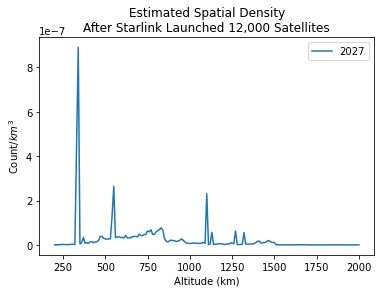

In [79]:
# Based on Starlink plans
# Source: https://en.wikipedia.org/wiki/Starlink
counts[2027] = counts[2020].copy()
densitys[2027] = {}

counts[2027][550] += 1440
counts[2027][1100] += 1600
counts[2027][1130] += 374
counts[2027][1270] += 450  # Actual: 1275
counts[2027][1320] += 400  # Actual: 1325
counts[2027][340] += 2478  # Actual: 340.8
counts[2027][330] += 2493  # Actual: 335.9
counts[2027][340] += 2547  # Actual: 345.6

for alt in counts[2027].keys():
    spatial_vol = altitude_band_volume(earth_radius+alt+bin_size, earth_radius+alt)
    densitys[2027][alt] = counts[2027][alt] / spatial_vol
    

plt.figure()
x = densitys[2027].keys()
y2027 = densitys[2027].values()
plt.plot(x,y2027, label='2027')
plt.xlabel("Altitude (km)")
plt.ylabel("Count/$km^3$")
plt.title("Estimated Spatial Density\nAfter Starlink Launched 12,000 Satellites")
plt.legend()
plt.show()

# Future Mass-Satellite Contellations

## Starlink
- 12,000 satellites (phase 1 and 2 scheduled to finish November 2027)
- Target orbits between 330km and 1275km - https://spacenews.com/spacex-submits-paperwork-for-30000-more-starlink-satellites/
- Additional 30,000 satellites planned for orbits 328 to 580km

## OneWeb
- 650 Satellites
- Resume launching Dec 2020 - https://www.oneweb.world/media-center/oneweb-and-arianespace-to-restart-launches-in-december-2020
- Next launch = 110 satellites
- 16 launches placing another 34-36 satellites per launch
- Target orbit = 1200 km

## Boeing (Boeing Satellite)
- 1396-2956 satellites - https://en.wikipedia.org/wiki/Satellite_constellation
- Target orbit = 1200 km

## Hongyan (CASTC - China Aerospace Science and Technology Corporation)
- 320-864 satellites - https://en.wikipedia.org/wiki/Satellite_constellation
- Target orbit = 1100–1175 km

## Project Kuiper (Amazon)
- 3236 satellites - https://en.wikipedia.org/wiki/Kuiper_Systems
- Target orbit = 590–630 km
- 98 orbital planes in three orbital shells, one each at 590 km, 610 km, and 630 km]

## Samsung
- 4600 satellites - https://www.popsci.com/samsung-wants-launch-thousands-satellites-bring-everyone-earth-internet/
- Target orbit = 1400 km

## Telesat
- 1600 satellites - https://en.wikipedia.org/wiki/Telesat
- Target orbit = 1000 km

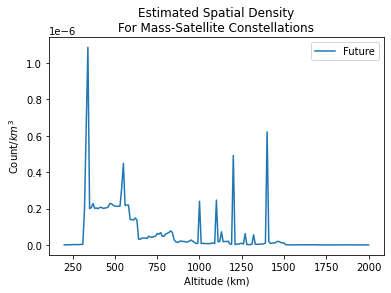

In [80]:
counts['Future'] = counts[2027].copy()
densitys['Future'] = {}

# Starlink additional 30,000 satellites
for a in np.arange(320,590,10):
    counts['Future'][a] += 1110

# OneWeb (currently 74)
counts['Future'][1200] += (650 - df['OBJECT_NAME'].str.startswith('ONEWEB').sum())

# Boeing
counts['Future'][1200] += 2956

# Hongyan's 864 satellites
for a in np.arange(1100,1180,10):
    counts['Future'][a] += 108

# Project Kuiper 3235 satellites
for a in np.arange(590,640,10):
    counts['Future'][a] += 647

# Samsung 4600 satellites
counts['Future'][1400] += 4600

# Telesat 1600 
counts['Future'][1000] += 1600


for alt in counts['Future'].keys():
    spatial_vol = altitude_band_volume(earth_radius+alt+bin_size, earth_radius+alt)
    densitys['Future'][alt] = counts['Future'][alt] / spatial_vol
    

plt.figure()
x = densitys['Future'].keys()
yFuture = densitys['Future'].values()
plt.plot(x,yFuture, label='Future')
plt.xlabel("Altitude (km)")
plt.ylabel("Count/$km^3$")
plt.title("Estimated Spatial Density\nFor Mass-Satellite Constellations")
plt.legend()
plt.show()

In [81]:
counts_df = pd.DataFrame(densitys)[[2020,2027,'Future']]
fig = px.line(counts_df, title='Satellite Density Considering Future Constellations',
              labels={
                  "index": "$Altitude (km)$",
                  "value": "$Count/km^3$",
                  "variable": "Year"
              })

# Arrows
fig.add_annotation(x=540, y=0.000000130, text='2020 Max<br>Spatial Density', showarrow=True, arrowhead=2,
                   arrowsize=1, arrowwidth=2, axref='x', ayref='y', ax=830, ay=0.0000005)
fig.add_annotation(x=830, y=0.000000079, text='2019 Max<br>Spatial Density', showarrow=True, arrowhead=2,
                   arrowsize=1, arrowwidth=2, axref='x', ayref='y', ax=830, ay=0.0000003)

# Starlink
fig.add_shape(dict(type="rect", x0=310, x1=585, y0=0, y1=1, yref='paper', fillcolor="yellow", line_color='yellow', opacity=0.1))
fig.add_shape(dict(type="rect", x0=1090, x1=1110, y0=0, y1=1, yref='paper', fillcolor="yellow", line_color='yellow', opacity=0.1))
fig.add_shape(dict(type="rect", x0=1120, x1=1140, y0=0, y1=1, yref='paper', fillcolor="yellow", line_color='yellow', opacity=0.1))
fig.add_shape(dict(type="rect", x0=1260, x1=1280, y0=0, y1=1, yref='paper', fillcolor="yellow", line_color='yellow', opacity=0.1))
fig.add_shape(dict(type="rect", x0=1310, x1=1330, y0=0, y1=1, yref='paper', fillcolor="yellow", line_color='yellow', opacity=0.1))
fig.add_annotation(x=460, y=0.0000011, text='Starlink<br>Constellation', showarrow=False)

# Project Kuiper
fig.add_shape(dict(type="rect", x0=585, x1=640, y0=0, y1=1, yref='paper', fillcolor="blue", line_color='blue', opacity=0.1))
fig.add_annotation(x=610, y=0.0000011, text='Project Kuiper<br>Constellation', showarrow=True, arrowhead=0,
                   arrowwidth=1, axref='x', ayref='y', ax=800, ay=0.0000011)

# OneWeb & Boeing
fig.add_shape(dict(type="rect", x0=1190, x1=1210, y0=0, y1=1, yref='paper', fillcolor="brown", line_color='brown', opacity=0.1))
fig.add_annotation(x=1200, y=0.0000009, text='OneWeb & Boeing<br>Constellations', showarrow=True, arrowhead=0,
                   arrowwidth=1, axref='x', ayref='y', ax=1600, ay=0.0000009)

# Hongyan
fig.add_shape(dict(type="rect", x0=1090, x1=1180, y0=0, y1=1, yref='paper', fillcolor="red", line_color='red', opacity=0.1))
fig.add_annotation(x=1170, y=0.0000007, text='Hongyan<br>Constellation', showarrow=True, arrowhead=0,
                   arrowwidth=1, axref='x', ayref='y', ax=1600, ay=0.0000007)
fig.add_annotation(x=1100, y=0.0000007, text='Hongyan & Starlink<br>Constellations', showarrow=True, arrowhead=0,
                   arrowwidth=1, axref='x', ayref='y', ax=800, ay=0.0000007)

# Samsung
fig.add_shape(dict(type="rect", x0=1390, x1=1410, y0=0, y1=1, yref='paper', fillcolor="green", line_color='green', opacity=0.1))
fig.add_annotation(x=1400, y=0.0000011, text='Samsung<br>Constellation', showarrow=True, arrowhead=0,
                   arrowwidth=1, axref='x', ayref='y', ax=1600, ay=0.0000011)

# Telesat
fig.add_shape(dict(type="rect", x0=990, x1=1010, y0=0, y1=1, yref='paper', fillcolor="purple", line_color='purple', opacity=0.1))
fig.add_annotation(x=1000, y=0.0000009, text='Telesat<br>Constellation', showarrow=True, arrowhead=0,
                   arrowwidth=1, axref='x', ayref='y', ax=800, ay=0.0000009)


fig.update_layout(plot_bgcolor='white')

fig.show()